In [1]:
#import required packages
import boto3
import requests
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import time
from pyathena import connect
import sagemaker
from sqlalchemy.engine import create_engine
import warnings
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker import image_uris
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Check s3 for files

In [2]:
# Create an S3 client
s3 = boto3.client('s3')

# List objects with the prefix
response = s3.list_objects_v2(Bucket='ecogridaidata', Prefix='eia_electricity/eia_data')

# Print the file keys
for obj in response.get('Contents', []):
    print(obj['Key'])

eia_electricity/eia_data_demand_20250324_225715.json
eia_electricity/eia_data_demand_20250325_021240.json
eia_electricity/eia_data_energy_source_20250323_200432.json
eia_electricity/eia_data_neighboring_bal_20250324_224805.json
eia_electricity/eia_data_subregion_20250323_191441.json
eia_electricity/eia_data_subregion_20250325_021741.json


Note: If data is not available, locate "RTC:ADS508TeamProject/installation/Installation & Set-Up.ipynb" notebook to run refesh data from the EIA website

## Load data stored as a json file in s3 "ecogridaidata" into a dataframe for verification and processing

In [3]:
# S3 path to your file
s3_uri = "s3://ecogridaidata/eia_electricity/eia_data_subregion_20250323_191441.json"
s3_uri2 = "s3://ecogridaidata/eia_electricity/eia_data_energy_source_20250323_200432.json"
s3_uri3 = "s3://ecogridaidata/eia_electricity/eia_data_neighboring_bal_20250324_224805.json"
s3_uri4 = "s3://ecogridaidata/eia_electricity/eia_data_demand_20250325_021240.json"

# Read json directly into pandas DataFrame
df_subregion = pd.read_json(s3_uri, storage_options={"anon": False})
df_energysource = pd.read_json(s3_uri2, storage_options={"anon": False})
df_neighbor_bal = pd.read_json(s3_uri3, storage_options={"anon": False})
df_demand = pd.read_json(s3_uri4, storage_options={"anon": False})

# Preview the data
df_subregion.head()

,period,subba,subba-name,parent,parent-name,timezone,value,value-units
0,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Arizona,247213,megawatthours
1,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Central,247876,megawatthours
2,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Eastern,248481,megawatthours
3,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Mountain,247213,megawatthours
4,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Pacific,246697,megawatthours


In [4]:
df_energysource.head()

,period,respondent,respondent-name,fueltype,type-name,timezone,timezone-description,value,value-units
0,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",COL,Coal,Arizona,Arizona,23782,megawatthours
1,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",COL,Coal,Central,Central,23309,megawatthours
2,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",COL,Coal,Eastern,Eastern,22893,megawatthours
3,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",COL,Coal,Mountain,Mountain,23782,megawatthours
4,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",COL,Coal,Pacific,Pacific,24422,megawatthours


In [5]:
df_neighbor_bal.head()

,period,fromba,fromba-name,toba,toba-name,timezone,value,value-units
0,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",MISO,"Midcontinent Independent System Operator, Inc.",Arizona,584,megawatthours
1,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",MISO,"Midcontinent Independent System Operator, Inc.",Central,359,megawatthours
2,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",MISO,"Midcontinent Independent System Operator, Inc.",Eastern,321,megawatthours
3,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",MISO,"Midcontinent Independent System Operator, Inc.",Mountain,584,megawatthours
4,2024-12-31,AECI,"Associated Electric Cooperative, Inc.",MISO,"Midcontinent Independent System Operator, Inc.",Pacific,1111,megawatthours


In [6]:
df_demand.head()

,period,respondent,respondent-name,type,type-name,timezone,timezone-description
0,2025-03-24,AECI,"Associated Electric Cooperative, Inc.",DF,Day-ahead demand forecast,Central,Central
1,2025-03-24,AECI,"Associated Electric Cooperative, Inc.",DF,Day-ahead demand forecast,Eastern,Eastern
2,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Arizona,Arizona
3,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Central,Central
4,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Eastern,Eastern


## Create Athena Database

In [7]:
# Save to CSV for Athena readability
df_subregion.to_csv("s3://ecogridaidata/eia_electricity/subregion.csv", index=False)
df_energysource.to_csv("s3://ecogridaidata/eia_electricity/data_csv/energysource.csv", index=False)
df_neighbor_bal.to_csv("s3://ecogridaidata/eia_electricity/data_csv/neighboring_bal.csv", index=False)
df_demand.to_csv("s3://ecogridaidata/eia_electricity/demand.csv", index=False)

In [8]:
# Setup
sess = sagemaker.Session()
bucket = 'ecogridaidata'
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

s3_staging_dir = f"s3://{bucket}/athena/staging"
database_name = "ecodataaidatabase"

# Connect
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cursor = conn.cursor()

# Create DB if needed
cursor.execute("CREATE DATABASE IF NOT EXISTS ecodataaidatabase")

In [9]:
# Subregion Table
query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.subregion (
    period string,
    subba string,
    `subba-name` string,
    parent string,
    `parent-name` string,
    timezone string,
    value int,
    `value-units` string
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "quoteChar" = "\\""
)
LOCATION 's3://{bucket}/athena/subregion/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

cursor = conn.cursor()
cursor.execute(query)

In [10]:
# Test Query Subregion
query = f"SELECT * FROM {database_name}.subregion LIMIT 10;"
df = pd.read_sql(query, conn)
df.head()

,period,subba,subba-name,parent,parent-name,timezone,value,value-units
0,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Arizona,247213,megawatthours
1,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Central,247876,megawatthours
2,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Eastern,248481,megawatthours
3,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Mountain,247213,megawatthours
4,2024-12-31,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,Pacific,246697,megawatthours


In [11]:
# Energy Source Table
query = """
CREATE EXTERNAL TABLE IF NOT EXISTS ecodataaidatabase.energysource (
    period string,
    respondent string,
    `respondent-name` string,
    fueltype string,
    `type-name` string,
    timezone string,
    `timezone-description` string,
    value int,
    `value-units` string
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "quoteChar" = "\\""
)
LOCATION 's3://ecogridaidata/athena/energysource/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""
cursor = conn.cursor()
cursor.execute(query)

In [12]:
# Neighboring Table
query = """
CREATE EXTERNAL TABLE IF NOT EXISTS ecodataaidatabase.neighboring_bal (
    period string,
    fromba string,
    `fromba-name` string,
    toba string,
    `toba-name` string,
    timezone string,
    value int,
    `value-units` string
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "quoteChar" = "\\""
)
LOCATION 's3://ecogridaidata/athena/neighboring_bal/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""
cursor = conn.cursor()
cursor.execute(query)

In [13]:
# Demand Table
query = """
CREATE EXTERNAL TABLE IF NOT EXISTS ecodataaidatabase.demand (
    period string,
    respondent string,
    `respondent-name` string,
    type string,
    `type-name` string,
    timezone string,
    `timezone-description` string,
    value int,
    `value-units` string
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "quoteChar" = "\\""
)
LOCATION 's3://ecogridaidata/athena/demand/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""
# Run the query
cursor = conn.cursor()
cursor.execute(query)

In [14]:
# Verification
df_tables = pd.read_sql(f"SHOW TABLES IN {database_name}", conn)
print(df_tables)

          tab_name
0           demand
1     energysource
2  neighboring_bal
3        subregion


In [15]:
if database_name in df_tables.values:
    ingest_create_athena_db_passed = True

## Exploratory Daya Analysis

In [16]:
for name, df in zip(
    ['Subregion', 'Energy Source', 'Neighbor Balancing', 'Demand'],
    [df_subregion, df_energysource, df_neighbor_bal, df_demand]
):
    print(f"\n=== {name} Dataset ===")
    print("Shape:", df.shape)
    print("Null values:\n", df.isnull().sum())
    print("Data types:\n", df.dtypes)


=== Subregion Dataset ===
Shape: (302719, 8)
Null values:
 period         0
subba          0
subba-name     0
parent         0
parent-name    0
timezone       0
value          0
value-units    0
dtype: int64
Data types:
 period         object
subba          object
subba-name     object
parent         object
parent-name    object
timezone       object
value           int64
value-units    object
dtype: object

=== Energy Source Dataset ===
Shape: (1425802, 9)
Null values:
 period                  0
respondent              0
respondent-name         0
fueltype                0
type-name               0
timezone                0
timezone-description    0
value                   0
value-units             0
dtype: int64
Data types:
 period                  object
respondent              object
respondent-name         object
fueltype                object
type-name               object
timezone                object
timezone-description    object
value                    int64
value-units    

Datasets do no contain any null values

In [17]:
dfs = [df_subregion, df_energysource, df_neighbor_bal, df_demand]
for df in dfs:
    df['period'] = pd.to_datetime(df['period'])

for name, df in zip(
    ['Subregion', 'Energy Source', 'Neighbor Balancing', 'Demand'],
    dfs
):
    years = df['period'].dt.year.unique()
    print(f"\n{name} years in data:", sorted(years))


Subregion years in data: [2023, 2024]

Energy Source years in data: [2023, 2024]

Neighbor Balancing years in data: [2023, 2024]

Demand years in data: [2025]


In [18]:
print(df_demand.columns)

Index(['period', 'respondent', 'respondent-name', 'type', 'type-name',
       'timezone', 'timezone-description'],
      dtype='object')


In [19]:
df_demand.head()

,period,respondent,respondent-name,type,type-name,timezone,timezone-description
0,2025-03-24,AECI,"Associated Electric Cooperative, Inc.",DF,Day-ahead demand forecast,Central,Central
1,2025-03-24,AECI,"Associated Electric Cooperative, Inc.",DF,Day-ahead demand forecast,Eastern,Eastern
2,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Arizona,Arizona
3,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Central,Central
4,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Eastern,Eastern


In [20]:
df_demand.dtypes

period                  datetime64[ns]
respondent                      object
respondent-name                 object
type                            object
type-name                       object
timezone                        object
timezone-description            object
dtype: object

In [21]:
for name, df in zip(
    ['Subregion', 'Energy Source', 'Neighbor Balancing', 'Demand'],
    [df_subregion, df_energysource, df_neighbor_bal, df_demand]
):
    print(f"\n{name} value stats:")
    if 'value' in df.columns:
        print(df['value'].describe())
    else:
        print("'value' column not found.")


Subregion value stats:
count    302719.000000
mean      87875.291197
std      108917.572342
min           0.000000
25%       18723.000000
50%       42308.000000
75%      109606.500000
max      785360.000000
Name: value, dtype: float64

Energy Source value stats:
count    1.425802e+06
mean     8.635683e+04
std      3.142995e+05
min     -2.444800e+04
25%      1.011000e+03
50%      9.493000e+03
75%      4.901500e+04
max      7.156358e+06
Name: value, dtype: float64

Neighbor Balancing value stats:
count    1.233232e+06
mean    -1.812310e+02
std      2.222270e+04
min     -1.772330e+05
25%     -5.127000e+03
50%      0.000000e+00
75%      4.588000e+03
max      3.494280e+05
Name: value, dtype: float64

Demand value stats:
'value' column not found.



Subregion value distribution:


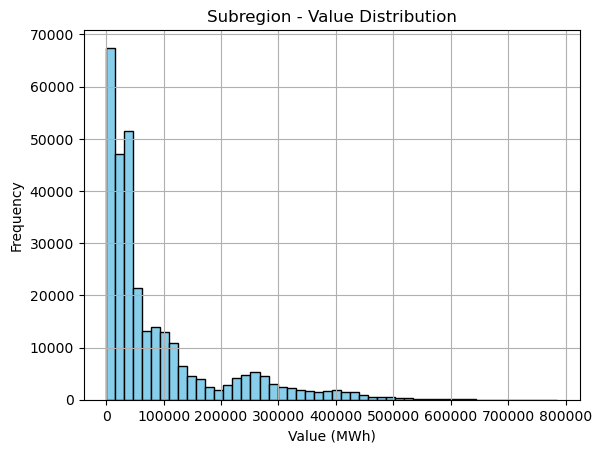


Energy Source value distribution:


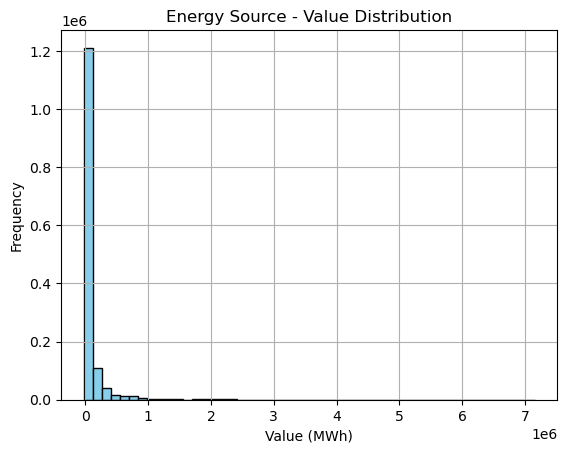


Neighbor Balancing value distribution:


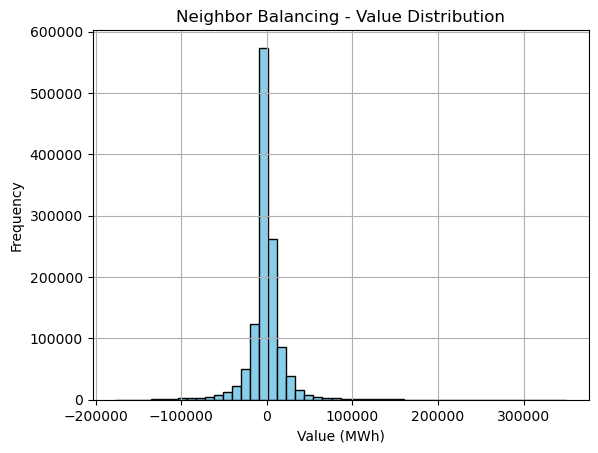

In [22]:
#Value Distribution

for name, df in zip(
    ['Subregion', 'Energy Source', 'Neighbor Balancing'],
    [df_subregion, df_energysource, df_neighbor_bal]
):
    if 'value' in df.columns:
        print(f"\n{name} value distribution:")
        plt.hist(df['value'], bins=50, color='skyblue', edgecolor='black')
        plt.title(f'{name} - Value Distribution')
        plt.xlabel('Value (MWh)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        print(f"'{name}' has no 'value' column.")


Subregion - Total Value Over Time:


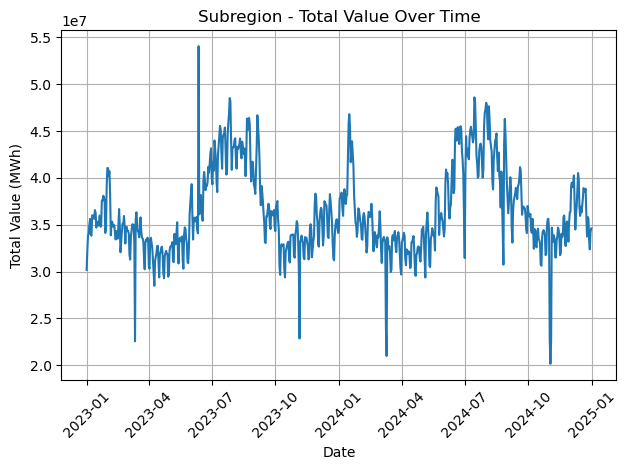


Energy Source - Total Value Over Time:


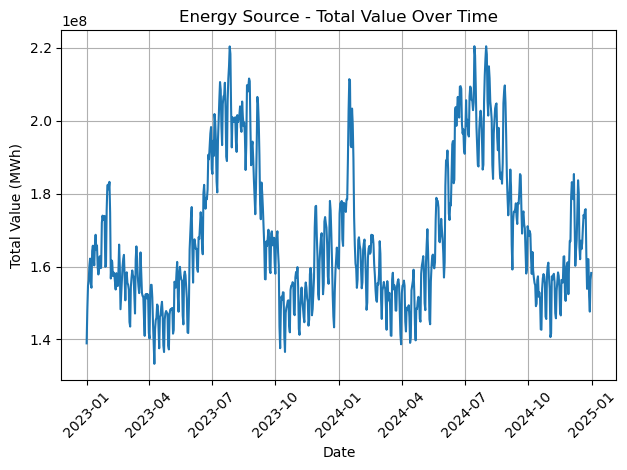


Neighbor Balancing - Total Value Over Time:


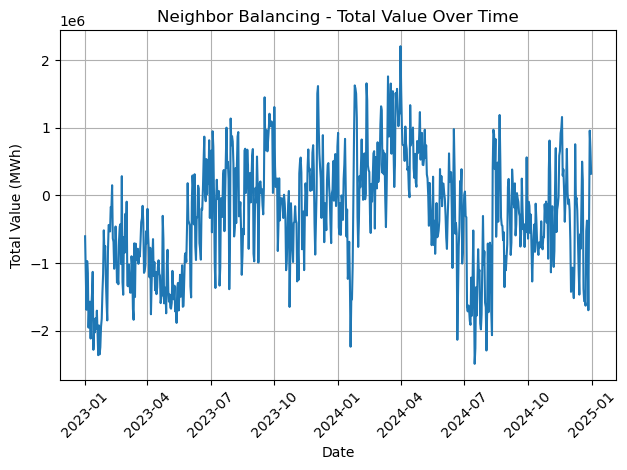

In [23]:
for name, df in zip(
    ['Subregion', 'Energy Source', 'Neighbor Balancing'],
    [df_subregion, df_energysource, df_neighbor_bal]
):
    if 'value' in df.columns:
        print(f"\n{name} - Total Value Over Time:")
        df_time = df.copy()
        df_time['period'] = pd.to_datetime(df_time['period'])
        
        df_time_grouped = df_time.groupby('period')['value'].sum().reset_index()

        plt.plot(df_time_grouped['period'].values, df_time_grouped['value'].values)
        plt.title(f'{name} - Total Value Over Time')
        plt.xlabel('Date')
        plt.ylabel('Total Value (MWh)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [24]:
#merge "value" across all datasets

df_subregion_time = df_subregion.groupby('period')['value'].sum().reset_index()
df_energysource_time = df_energysource.groupby('period')['value'].sum().reset_index()
df_neighbor_time = df_neighbor_bal.groupby('period')['value'].sum().reset_index()

In [25]:
#merge for plotting

merged = df_subregion_time.merge(df_energysource_time, on='period', suffixes=('_subregion', '_energysource'))
merged = merged.merge(df_neighbor_time, on='period')
merged.rename(columns={'value': 'value_neighbor'}, inplace=True)

In [26]:
print(merged.columns)
print(merged.dtypes)

Index(['period', 'value_subregion', 'value_energysource', 'value_neighbor'], dtype='object')
period                datetime64[ns]
value_subregion                int64
value_energysource             int64
value_neighbor                 int64
dtype: object


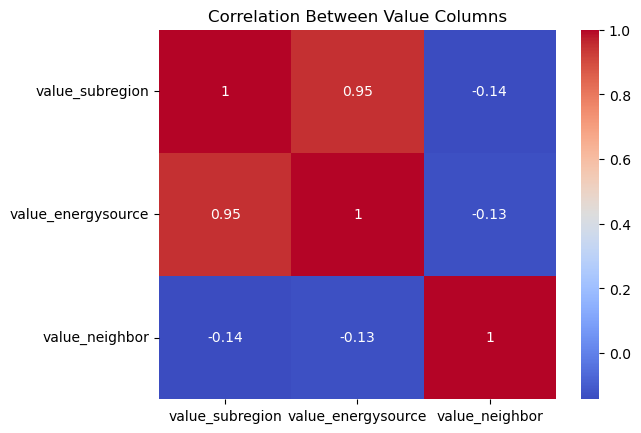

In [27]:
correlation_matrix = merged[['value_subregion', 'value_energysource', 'value_neighbor']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Value Columns')
plt.show()

## Data Preparation

In [28]:
# --- Subregion Dataset ---
query_subregion = "SELECT * FROM ecodataaidatabase.subregion"
df_subregion = pd.read_sql(query_subregion, conn)

# Clean: drop unnecessary columns
df_subregion.drop(columns=['subba-name', 'parent-name', 'value-units'], inplace=True)

# Scrub: drop duplicates and rows missing critical fields
df_subregion.drop_duplicates(inplace=True)
df_subregion.dropna(subset=['period', 'value'], inplace=True)

# Feature engineering: convert period to datetime and create new features
df_subregion['period'] = pd.to_datetime(df_subregion['period'])
df_subregion['month'] = df_subregion['period'].dt.month
df_subregion['weekday'] = df_subregion['period'].dt.weekday

# Preview
print("Subregion DataFrame after cleaning:")
display(df_subregion.head())

Subregion DataFrame after cleaning:


,period,subba,parent,timezone,value,month,weekday
0,2024-12-31,PGAE,CISO,Arizona,247213,12,1
1,2024-12-31,PGAE,CISO,Central,247876,12,1
2,2024-12-31,PGAE,CISO,Eastern,248481,12,1
3,2024-12-31,PGAE,CISO,Mountain,247213,12,1
4,2024-12-31,PGAE,CISO,Pacific,246697,12,1


In [29]:
# --- Energysource Dataset ---
query_energysource = "SELECT * FROM ecodataaidatabase.energysource"
df_energysource = pd.read_sql(query_energysource, conn)

# Clean: drop unnecessary columns
df_energysource.drop(columns=['respondent-name', 'type-name', 'timezone-description', 'value-units'], inplace=True)

# Scrub: drop duplicates and rows missing critical fields
df_energysource.drop_duplicates(inplace=True)
df_energysource.dropna(subset=['period', 'value', 'fueltype'], inplace=True)

# Feature engineering: convert period to datetime and add time features
df_energysource['period'] = pd.to_datetime(df_energysource['period'])
df_energysource['month'] = df_energysource['period'].dt.month
df_energysource['weekday'] = df_energysource['period'].dt.weekday

# Preview
print("Energysource DataFrame after cleaning:")
display(df_energysource.head())

Energysource DataFrame after cleaning:


,period,respondent,fueltype,timezone,value,month,weekday
0,2023-12-12,SE,NG,Eastern,442347,12,1
1,2023-12-12,SE,NG,Mountain,440939,12,1
2,2023-12-12,SE,NG,Pacific,439671,12,1
3,2023-12-12,SE,NUC,Arizona,168001,12,1
4,2023-12-12,SE,NUC,Central,168034,12,1


In [30]:
# --- Neighboring Balancing Dataset ---
query_neighboring = "SELECT * FROM ecodataaidatabase.neighboring_bal"
df_neighboring_bal = pd.read_sql(query_neighboring, conn)

# Clean: drop unnecessary columns
df_neighboring_bal.drop(columns=['fromba-name', 'toba-name', 'value-units'], inplace=True)

# Scrub: drop duplicates and rows missing critical fields
df_neighboring_bal.drop_duplicates(inplace=True)
df_neighboring_bal.dropna(subset=['period', 'value', 'fromba', 'toba'], inplace=True)

# Feature engineering: convert period to datetime and add new features
df_neighboring_bal['period'] = pd.to_datetime(df_neighboring_bal['period'])
df_neighboring_bal['month'] = df_neighboring_bal['period'].dt.month
df_neighboring_bal['weekday'] = df_neighboring_bal['period'].dt.weekday

# Preview
print("Neighboring Balancing DataFrame after cleaning:")
display(df_neighboring_bal.head())

Neighboring Balancing DataFrame after cleaning:


,period,fromba,toba,timezone,value,month,weekday
0,2024-12-31,AECI,MISO,Arizona,584,12,1
1,2024-12-31,AECI,MISO,Central,359,12,1
2,2024-12-31,AECI,MISO,Eastern,321,12,1
3,2024-12-31,AECI,MISO,Mountain,584,12,1
4,2024-12-31,AECI,MISO,Pacific,1111,12,1


In [31]:
# --- Demand Dataset ---
query_demand = "SELECT * FROM ecodataaidatabase.demand"
df_demand = pd.read_sql(query_demand, conn)

# Scrub: drop duplicates and rows missing critical fields
df_demand.drop_duplicates(inplace=True)
df_demand.dropna(subset=['period', 'value'], inplace=True)

# Feature engineering: convert period to datetime and add new features
df_demand['period'] = pd.to_datetime(df_demand['period'])
df_demand['month'] = df_demand['period'].dt.month
df_demand['weekday'] = df_demand['period'].dt.weekday

# Preview
print("Demand DataFrame after cleaning:")
display(df_demand.head())

Demand DataFrame after cleaning:


,period,respondent,respondent-name,type,type-name,timezone,timezone-description,value,value-units,month,weekday


In [32]:
#Split datasets into train, validation, and test sets

# Define Train/Validation/Test Split Dates
train_cutoff = '2024-10-31'
val_cutoff = '2024-11-30'

# Split by Date
def time_split(df, date_col='period'):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)
    df_train = df[df[date_col] <= train_cutoff]
    df_val = df[(df[date_col] > train_cutoff) & (df[date_col] <= val_cutoff)]
    df_test = df[df[date_col] > val_cutoff]
    return df_train, df_val, df_test

#Apply Split to all datasets
dfs_cleaned = {
    'subregion': df_subregion,
    'energysource': df_energysource,
    'neighbor_bal': df_neighboring_bal,
    'demand': df_demand
}

split_datasets = {}

for name, df in dfs_cleaned.items():
    train_df, val_df, test_df = time_split(df)
    split_datasets[name] = {
        'train': train_df,
        'val': val_df,
        'test': test_df
    }
    print(f"{name} split: train({len(train_df)}), val({len(val_df)}), test({len(test_df)})")

subregion split: train(277742), val(12112), test(12865)
energysource split: train(1302730), val(60202), test(62870)
neighbor_bal split: train(1130527), val(50080), test(52625)
demand split: train(0), val(0), test(0)


In [33]:
# Test Demand Query
df = pd.read_sql("SELECT * FROM ecodataaidatabase.demand LIMIT 10;", conn)
df.head()

,period,respondent,respondent-name,type,type-name,timezone,timezone-description,value,value-units
0,2025-03-24,AECI,"Associated Electric Cooperative, Inc.",DF,Day-ahead demand forecast,Central,Central,None,None
1,2025-03-24,AECI,"Associated Electric Cooperative, Inc.",DF,Day-ahead demand forecast,Eastern,Eastern,None,None
2,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Arizona,Arizona,None,None
3,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Central,Central,None,None
4,2025-03-24,AVA,Avista Corporation,DF,Day-ahead demand forecast,Eastern,Eastern,None,None


In [34]:
#prepare dataset for forecasting
# Step 1: Setup
session = sagemaker.Session()
role = get_execution_role()
bucket = 'ecogridaidata'
prefix = 'eia_electricity/cleaned'
region = boto3.Session().region_name
container = image_uris.retrieve(region=region, framework='forecasting-deepar')

# Step 2: Preprocess dataset
df = split_datasets['subregion']['train'].copy()

# Format timestamp and item_id
df['timestamp'] = pd.to_datetime(df['period'])
df['item_id'] = df['subba'] + '_' + df['parent'] + '_' + df['timezone']
df['target'] = df['value']

# Select and reorder required columns
df = df[['timestamp', 'item_id', 'target']]

# Group each time series by item_id
def format_series(group):
    return {
        "start": str(group['timestamp'].min()),
        "target": group.sort_values('timestamp')['target'].tolist()
    }

json_series = df.groupby('item_id').apply(format_series).tolist()
json_lines = '\n'.join([str(obj).replace("'", '"') for obj in json_series])

[04/15/25 03:09:37] INFO     Same images used for training and inference. Defaulting to image     ]8;id=871853;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=968287;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=517213;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=170814;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [35]:
df 

,timestamp,item_id,target
302718,2023-01-01,WR_SWPP_Pacific,70108
302434,2023-01-01,ZONA_NYIS_Arizona,35990
302435,2023-01-01,ZONA_NYIS_Central,36031
302436,2023-01-01,ZONA_NYIS_Eastern,36075
302437,2023-01-01,ZONA_NYIS_Mountain,35990
...,...,...,...
25253,2024-10-31,PS_PJM_Central,108208
25260,2024-10-31,RECO_PJM_Mountain,3778
25252,2024-10-31,PS_PJM_Arizona,108784
25254,2024-10-31,PS_PJM_Eastern,107909


In [36]:
#save as csv and load to s3
s3_key = f'{prefix}/train/train.json'
s3_path = f's3://{bucket}/{s3_key}'

s3 = boto3.client('s3')
s3.put_object(Bucket=bucket, Key=s3_key, Body=json_lines)

{'ResponseMetadata': {'RequestId': 'A36TBZDCF4T379ZS',
  'HostId': '9Z7L2zLDa2EABEVjlx/SJ9Q6SUmss4ar5x3kM4dpXVI/+y6CAmhqMAMBOJB3u+Yx7O1uqgrzBCKHJno6uuWT6tyDuUMmeizk',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '9Z7L2zLDa2EABEVjlx/SJ9Q6SUmss4ar5x3kM4dpXVI/+y6CAmhqMAMBOJB3u+Yx7O1uqgrzBCKHJno6uuWT6tyDuUMmeizk',
   'x-amz-request-id': 'A36TBZDCF4T379ZS',
   'date': 'Tue, 15 Apr 2025 03:09:39 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"94c4e621a2b51e645041deb2461b79b0"',
   'x-amz-checksum-crc32': 'IHYn3w==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"94c4e621a2b51e645041deb2461b79b0"',
 'ChecksumCRC32': 'IHYn3w==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}

In [37]:
#train the model
hyperparameters = {
    "time_freq": "D",
    "epochs": "20",
    "early_stopping_patience": "10",
    "mini_batch_size": "64",
    "learning_rate": "0.001",
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "context_length": "30",            
    "prediction_length": "14" 
}

estimator = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=session,
    hyperparameters=hyperparameters
)

estimator.fit({'train': s3_path})

[04/15/25 03:09:38] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=461107;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=983835;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=980278;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=625860;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-04-15-03-09-38-360                                            

2025-04-15 03:09:41 Starting - Starting the training job...
..25-04-15 03:09:56 Starting - Preparing the instances for training.
..............10:35 Downloading - Downloading the training image.
Docker entrypoint called with argument(s): trainmpleted. Training in progress..
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/15/2025 03:13:12 INFO 140116693747520] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'n